# Pruebas simulación TEMPEST HDMI

## Importar librerías y funciones

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
from scipy import signal
import time
from PIL import Image
from DTutils import TMDS_encoding, TMDS_serial

## Código de simulación

### Levantar imagen de prueba

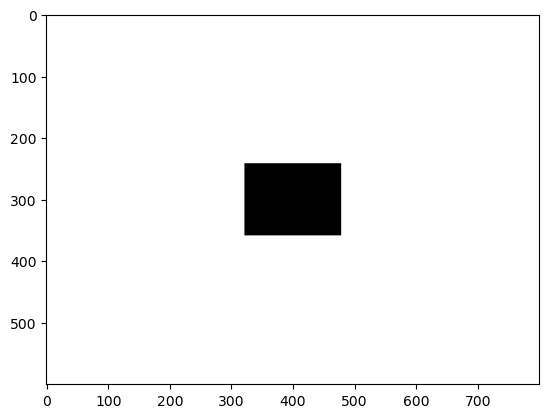

In [12]:
# I=imread('../images/VAMO!!.png')
I=imread('../images/black_cube_800x600.jpg')
# I=imread('../images/1920x1080_test2.png')
plt.figure()
plt.imshow(I)
plt.show()

v_active, h_active = I.shape[:2]

### Codificar imagen y serializar los bits de forma tipo "raster"

In [13]:
# Codificación TMDS
t1_TMDS = time.time()
I_TMDS = TMDS_encoding (I, blanking = True)
t2_TMDS = time.time()
# Serialización y efecto de superposición de canales RGB
t1_serial = time.time()
I_TMDS_Tx = TMDS_serial(I_TMDS)
t2_serial = time.time()

In [14]:
t_delay_TMDS = t2_TMDS - t1_TMDS
t_delay_serial = t2_serial - t1_serial
print('La codificación demora',t_delay_TMDS,'segundos')
print('La serialización demora',t_delay_serial,'segundos')
t_delay_serial+t_delay_TMDS

La codificación demora 2.4748852252960205 segundos
La serialización demora 3.423577070236206 segundos


5.898462295532227

In [15]:
# Resolución (con blanking)
v_total, h_total = I_TMDS.shape[:2]

fps = 60
px_rate = h_total*v_total*fps
bit_rate = 10*px_rate
# Tiempo continuo de transmisión de bits
t_continuous = np.arange(len(I_TMDS_Tx))/bit_rate

# Armónico elegido para centrar el espectro
N_harm = 3
harm = N_harm*px_rate

baseband_exponential = np.exp(2j*np.pi*harm*t_continuous)

In [16]:
# Tasa de muestreo del SDR
usrp_rate = 50e6

# samp_error_norm = 0.5916 # Este número sincroniza el VAMO pero esta mezclado
samp_error_norm = 0

# Muestreo de señal analógica
I_Rx = signal.resample_poly(I_TMDS_Tx*baseband_exponential,up=int(usrp_rate*(1+samp_error_norm)), down=bit_rate)

In [17]:
# I_reconstruct = np.abs(I_Rx[:(len(I_Rx)//h_total)*h_total]).reshape((len(I_Rx)//h_total,h_total))
I_reconstruct = np.abs(I_Rx)

In [18]:
I_reconst_px = np.abs(signal.resample(I_reconstruct, h_total*v_total).reshape(v_total,h_total))

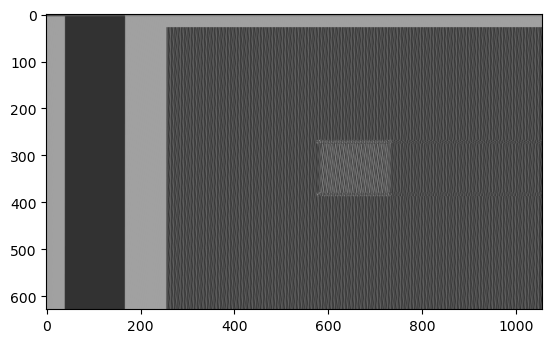

In [19]:
plt.figure()
plt.imshow(I_reconst_px, cmap='gray')
plt.show()

In [20]:
# I_reconst_px_active = I_reconst_px[-v_active:,-h_active:]
I_reconst_px_active = I_reconst_px
I_reconst_px_active = I_reconst_px_active - np.min(I_reconst_px_active)
I_reconst_px_active = 255*I_reconst_px_active/np.max(I_reconst_px_active)

im = Image.fromarray(I_reconst_px_active.astype('uint8'))
im.save("black_cube_TMDS_simulation.jpg")